In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

In [6]:
df = pd.read_csv("wine-reviews.csv", usecols=["country", "description", "points", "price", "variety", "winery"])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [7]:
df.dropna(subset=["description", "points"])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


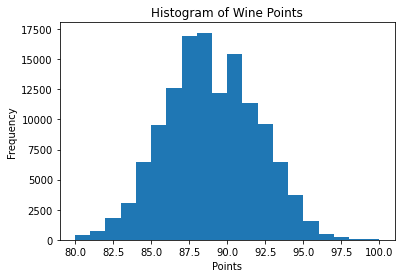

In [8]:
plt.hist(df.points, bins=20)
plt.title("Histogram of Wine Points")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

In [12]:
#creating a new label that will be boolean if wine points are greater or equal than 90 and forced as integer
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "points", "label"]]

In [16]:
#splitting the data into training and testing data using numpy
train, val, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

In [20]:
#Convert df to dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [21]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [40]:
#Embedding the data using tensorflow_hub and model this is for make the sentences as number that the computer can use
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2",dtype=tf.string, trainable=True)


In [41]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.09708833, -0.4200862 ,  0.09133515, ...,  0.20984809,
         0.05130185, -0.13372165],
       [ 0.3281466 , -0.09738593,  0.0897476 , ..., -0.13763905,
        -0.09646782,  0.04110467],
       [ 0.5462656 ,  0.15163091,  0.04744093, ..., -0.18291135,
        -0.3711828 ,  0.28920412],
       ...,
       [ 0.31601503, -0.09737115,  0.16393305, ..., -0.38359067,
        -0.20859325,  0.00250994],
       [ 0.5569515 , -0.04860537, -0.07516894, ...,  0.02447788,
        -0.27129993, -0.02990538],
       [ 0.683379  ,  0.10914377, -0.07067919, ...,  0.01817872,
        -0.36756304, -0.23405115]], dtype=float32)>

In [42]:
#creating a model using tensorflow keras addind a dropout
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4)) #this dropout layer is used to generalize a little bit
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [43]:
#compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) #probably this needs ['accuracy']

In [44]:
#evaluating the untrained model
model.evaluate(train_data)

102/102 [==============================] - 2s 11ms/step - loss: 0.7078 - accuracy: 0.3805


[0.7078285217285156, 0.3805108964443207]

In [35]:
#evaluating the untrained model with valid data
model.evaluate(valid_data)

13/13 [==============================] - 0s 10ms/step - loss: 0.7397 - accuracy: 0.3720


[0.7397177815437317, 0.37200891971588135]

In [45]:
#fitting the model
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 34s 325ms/step - loss: 0.4997 - accuracy: 0.7442 - val_loss: 0.3958 - val_accuracy: 0.8176
Epoch 2/5
102/102 [==============================] - 32s 317ms/step - loss: 0.3788 - accuracy: 0.8351 - val_loss: 0.3845 - val_accuracy: 0.8263
Epoch 3/5
102/102 [==============================] - 31s 302ms/step - loss: 0.3405 - accuracy: 0.8528 - val_loss: 0.3871 - val_accuracy: 0.8223
Epoch 4/5
102/102 [==============================] - 31s 301ms/step - loss: 0.3137 - accuracy: 0.8653 - val_loss: 0.3955 - val_accuracy: 0.8243
Epoch 5/5
102/102 [==============================] - 31s 300ms/step - loss: 0.2858 - accuracy: 0.8761 - val_loss: 0.4219 - val_accuracy: 0.8203


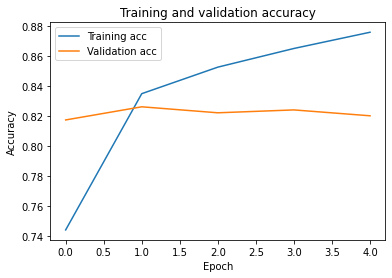

In [46]:
#plotting model history
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

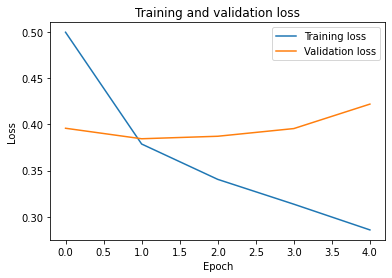

In [47]:
#plotting model history loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#The model is overfitted, is good to predict trainind data but bas generalizing to fix it we can use drop out

In [48]:
#evaluate the model with test data
model.evaluate(test_data)

13/13 [==============================] - 1s 48ms/step - loss: 0.4125 - accuracy: 0.8264


[0.41246965527534485, 0.826434850692749]

In [49]:
#lstm model
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [50]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [52]:
#creating a lstm model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True,
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [54]:
#evaluating the model with training data
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 119ms/step - loss: 0.6920 - accuracy: 0.6198


[0.6919806003570557, 0.6197584271430969]

In [55]:
#fitting the model
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 33s 289ms/step - loss: 0.5368 - accuracy: 0.7212 - val_loss: 0.3867 - val_accuracy: 0.8185
Epoch 2/5
102/102 [==============================] - 31s 305ms/step - loss: 0.3682 - accuracy: 0.8351 - val_loss: 0.3582 - val_accuracy: 0.8340
Epoch 3/5
102/102 [==============================] - 31s 303ms/step - loss: 0.3500 - accuracy: 0.8442 - val_loss: 0.3541 - val_accuracy: 0.8366
Epoch 4/5
102/102 [==============================] - 31s 307ms/step - loss: 0.3419 - accuracy: 0.8482 - val_loss: 0.3596 - val_accuracy: 0.8332
Epoch 5/5
102/102 [==============================] - 29s 287ms/step - loss: 0.3392 - accuracy: 0.8496 - val_loss: 0.3562 - val_accuracy: 0.8383


In [56]:
#evaluating the model with test data
model.evaluate(test_data)

13/13 [==============================] - 2s 113ms/step - loss: 0.3416 - accuracy: 0.8451


[0.3416171073913574, 0.8451300263404846]

In [58]:
valid_data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [59]:
model.save("modelWine.model")

INFO:tensorflow:Assets written to: modelWine.model\assets


INFO:tensorflow:Assets written to: modelWine.model\assets


In [64]:
model = tf.keras.models.load_model("modelWine.model")
CATEGORIES = ["Not Good", "Good"]

In [72]:
prediction = model.predict(test_data.take(1))
print(CATEGORIES[int(prediction[0][0])])

1/1 [==============================] - 0s 180ms/step
Not Good
